# Решение задачи регрессии точек с использованием модели YoloV5 и обучением по нескольким примерам

В ноутбуке проверяется подход к решению задачи регрессии ключевых точек с помощью построения модели регрессии на feature map предобученной модели

* получаем feature map с помощью модели YoloV5
* тренируем модели линейной регрессии решать задачу k-points

Использованы картинки из датасета https://www.kaggle.com/datasets/crawford/cat-dataset

In [1]:
import pathlib
import random
import sys

import albumentations as A
import cv2
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
import torch
from sklearn.decomposition import PCA
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score
from tqdm.cli import tqdm

sys.path.append("../yolov5")

In [2]:
from assh_utils import Batch

In [3]:
import os

root = "/home/asciishell/s3/asciishell-fsod/cats/CAT_00/"
images = [root + x for x in os.listdir(root) if x.endswith(".jpg")]
len(images)

1706

In [4]:
from models.common import AutoShape, DetectMultiBackend

In [5]:
model = AutoShape(DetectMultiBackend("./yolov5x.pt"))

Fusing layers... 
YOLOv5x summary: 444 layers, 86705005 parameters, 0 gradients, 205.7 GFLOPs
Adding AutoShape... 


In [6]:
%matplotlib inline

## Feature map visualisation

In [14]:
x = model(images[0], profile=pathlib.Path("vis"))

Saving vis/stage0_Conv_features.png... (32/80)
Saving vis/stage1_Conv_features.png... (32/160)
Saving vis/stage2_C3_features.png... (32/160)
Saving vis/stage3_Conv_features.png... (32/320)
Saving vis/stage4_C3_features.png... (32/320)
Saving vis/stage5_Conv_features.png... (32/640)
Saving vis/stage6_C3_features.png... (32/640)
Saving vis/stage7_Conv_features.png... (32/1280)
Saving vis/stage8_C3_features.png... (32/1280)
Saving vis/stage9_SPPF_features.png... (32/1280)
Saving vis/stage10_Conv_features.png... (32/640)
Saving vis/stage11_Upsample_features.png... (32/640)
Saving vis/stage12_Concat_features.png... (32/1280)
Saving vis/stage13_C3_features.png... (32/640)
Saving vis/stage14_Conv_features.png... (32/320)
Saving vis/stage15_Upsample_features.png... (32/320)
Saving vis/stage16_Concat_features.png... (32/640)
Saving vis/stage17_C3_features.png... (32/320)
Saving vis/stage18_Conv_features.png... (32/320)
Saving vis/stage19_Concat_features.png... (32/640)
Saving vis/stage20_C3_fea

We can fisualise feature map in the intermediate layers

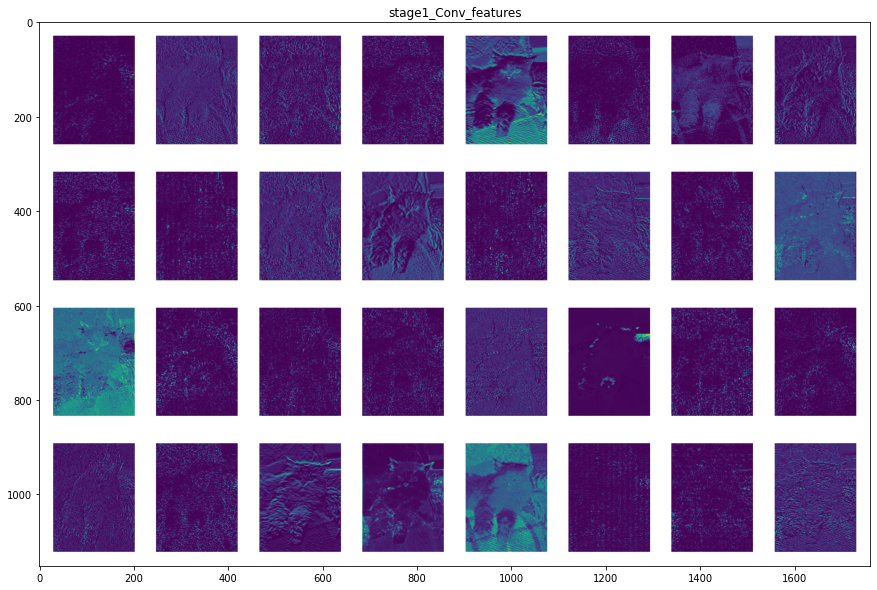

In [16]:
im = cv2.imread("vis/stage1_Conv_features.png", cv2.IMREAD_COLOR)
im = cv2.cvtColor(im, cv2.COLOR_BGR2RGB)
plt.figure(figsize=(25, 10))
plt.title("stage1_Conv_features")
plt.imshow(im)
plt.show()

Features are taken from 9th layer - last yolo backbone layer

see https://github.com/AsciiShell/yolov5/blob/master/models/yolov5x.yaml
```
# YOLOv5 v6.0 backbone
backbone:
  # [from, number, module, args]
  [[-1, 1, Conv, [64, 6, 2, 2]],  # 0-P1/2
   [-1, 1, Conv, [128, 3, 2]],  # 1-P2/4
   [-1, 3, C3, [128]],
   [-1, 1, Conv, [256, 3, 2]],  # 3-P3/8
   [-1, 6, C3, [256]],
   [-1, 1, Conv, [512, 3, 2]],  # 5-P4/16
   [-1, 9, C3, [512]],
   [-1, 1, Conv, [1024, 3, 2]],  # 7-P5/32
   [-1, 3, C3, [1024]],
   [-1, 1, SPPF, [1024, 5]],  # 9
  ]
```

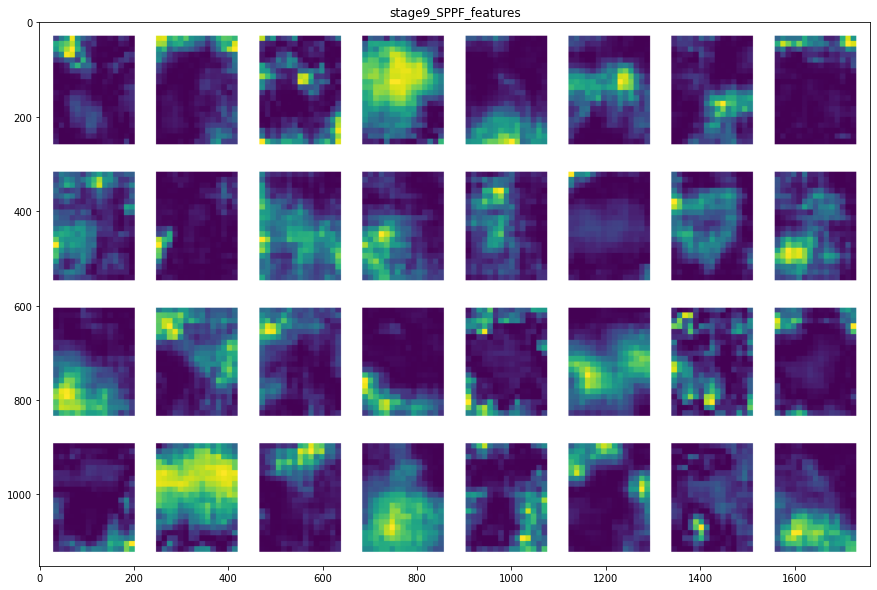

In [17]:
im = cv2.imread("vis/stage9_SPPF_features.png", cv2.IMREAD_COLOR)
im = cv2.cvtColor(im, cv2.COLOR_BGR2RGB)
plt.figure(figsize=(25, 10))
plt.title("stage9_SPPF_features")
plt.imshow(im)
plt.show()

## Model training

Для обучения будем брать центральный вектор из feature map + еще N - 1 ближайших векторов, где $N = (N_{neig} \cdot 2 + 1)^2$

Для каждого из N векторов target будет немного отличаться (k-points вычисляются осносительно центра выбранного вектора)

При инференсе реализован предикт для N векторов и усреднение предсказаний

In [7]:
for names in tqdm(Batch(images, 9)):
    # read images and data
    cat_names = names.copy()
    cat_target = []
    for cat_name in cat_names:
        with open(cat_name + ".cat") as f:
            cat_target.append([int(x) for x in f.read().split(" ")[1:-1]])
    cat_target = np.array(cat_target)
    cat_target = np.hstack([cat_target[:, ::2], cat_target[:, 1::2]])
    break

  0%|          | 0/190 [00:00<?, ?it/s]


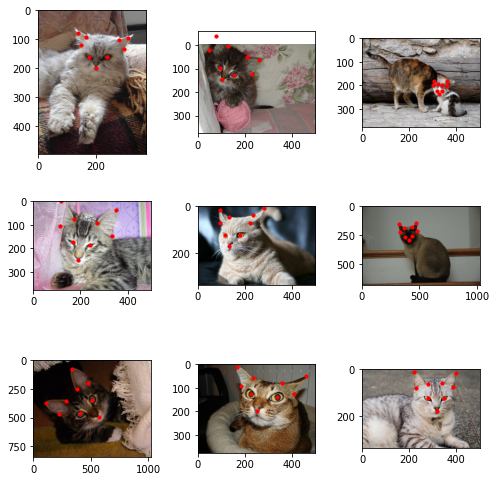

In [8]:
plt.figure(figsize=(7, 7), facecolor="w")
for i in range(len(cat_target)):
    plt.subplot(3, 3, i + 1)
    im = cv2.imread(cat_names[i], cv2.IMREAD_COLOR)
    im = cv2.cvtColor(im, cv2.COLOR_BGR2RGB)
    plt.imshow(im)
    plt.scatter(cat_target[i][:9], cat_target[i][9:], s=10, c="red")
plt.tight_layout()
plt.show()

In [9]:
BATCH_SIZE = 32
TRAIN_SIZE = 16
FEATURE_MAP_SIZE = 32
NUM_VEC = 3

feature map Yolo для применения в батче и для одной картинки сильно отличается, поэтому будем заранее использовать препроцессор к картинке - чтобы размеры feature map совпадали для разных изображений

также аналогичный процессинг применяем и для kpoints

In [10]:
def letterbox(
    im, key_x, key_y, new_shape=(640, 640), color=(114, 114, 114), auto=True, scaleFill=False, scaleup=True, stride=32
):
    """
    source https://github.com/ultralytics/yolov5/blob/master/utils/augmentations.py#L91
    В функцию добавлено преобразование для kpoints 
    """
    # Resize and pad image while meeting stride-multiple constraints
    shape = im.shape[:2]  # current shape [height, width]
    if isinstance(new_shape, int):
        new_shape = (new_shape, new_shape)

    # Scale ratio (new / old)
    r = min(new_shape[0] / shape[0], new_shape[1] / shape[1])
    if not scaleup:  # only scale down, do not scale up (for better val mAP)
        r = min(r, 1.0)

    # Compute padding
    ratio = r, r  # width, height ratios
    new_unpad = int(round(shape[1] * r)), int(round(shape[0] * r))
    dw, dh = new_shape[1] - new_unpad[0], new_shape[0] - new_unpad[1]  # wh padding
    if auto:  # minimum rectangle
        dw, dh = np.mod(dw, stride), np.mod(dh, stride)  # wh padding
    elif scaleFill:  # stretch
        dw, dh = 0.0, 0.0
        new_unpad = (new_shape[1], new_shape[0])
        ratio = new_shape[1] / shape[1], new_shape[0] / shape[0]  # width, height ratios

    dw /= 2  # divide padding into 2 sides
    dh /= 2

    if shape[::-1] != new_unpad:  # resize
        im = cv2.resize(im, new_unpad, interpolation=cv2.INTER_LINEAR)
        scale_x = shape[1] / new_unpad[0]
        scale_y = shape[0] / new_unpad[1]
        key_x = key_x / scale_x
        key_y = key_y / scale_y
    top, bottom = int(round(dh - 0.1)), int(round(dh + 0.1))
    left, right = int(round(dw - 0.1)), int(round(dw + 0.1))
    im = cv2.copyMakeBorder(im, top, bottom, left, right, cv2.BORDER_CONSTANT, value=color)  # add border
    key_x += left
    key_y += top
    return im, ratio, (dw, dh), (key_x, key_y)


def scale_coords(img1_shape, img0_shape, key_x, key_y):
    """
    source https://github.com/ultralytics/yolov5/blob/master/utils/general.py#L709
    Функция исправлена для применения преобразования к kpoints
    """
    # Rescale coords (xyxy) from img1_shape to img0_shape
    # calculate from img0_shape
    key_x = key_x.copy()
    key_y = key_y.copy()
    gain = min(img1_shape[0] / img0_shape[0], img1_shape[1] / img0_shape[1])  # gain  = old / new
    pad = (img1_shape[1] - img0_shape[1] * gain) / 2, (img1_shape[0] - img0_shape[0] * gain) / 2  # wh padding
    key_x -= pad[0]
    key_y -= pad[1]
    key_x /= gain
    key_y /= gain
    return key_x, key_y


def preproc_img(im, key_x, key_y):
    """
    Функция предобработки изображения 
    Применение данной функции к каждому изображению позволяет
    получать feature map одинакового размера для всех изображений по отдельности
    (как если бы подавались все изображения в одном батче)
    """
    key_x = key_x.copy()
    key_y = key_y.copy()
    im = im.copy()
    res = letterbox(im, key_x, key_y, [640, 640, 32], auto=False)
    im, keys = res[0], res[-1]
    im = im.transpose((2, 0, 1))[::-1]
    im = np.ascontiguousarray(im)
    return im, keys[0], keys[1]

In [11]:
def predict(X, regr, inputs):
    """
    Получение, усреднение и обратное преобразование предсказаний
    """
    prediction = []
    output = regr.predict(X).reshape((-1, (NUM_VEC * 2 + 1) ** 2, 18))

    for i in range(len(output)):
        h = inputs[i]["height"]
        w = inputs[i]["width"]
        pred = []
        for fm in output[i]:
            x_output = fm[:9] * FEATURE_MAP_SIZE
            y_output = fm[9:] * FEATURE_MAP_SIZE
            x_output += (np.round(np.ceil(640 / FEATURE_MAP_SIZE) / 2) + 0.5) * FEATURE_MAP_SIZE
            y_output += (np.round(np.ceil(640 / FEATURE_MAP_SIZE) / 2) + 0.5) * FEATURE_MAP_SIZE
            key_x, key_y = scale_coords((640, 640), (h, w), x_output, y_output)
            pred.append(np.hstack([key_x, key_y]))
        prediction.append(np.array(pred).mean(axis=0))
    return prediction

Выберем оптимальное кол-во PCA

In [12]:
metrics = []
for names in tqdm(Batch(images, BATCH_SIZE)):
    if len(names) < BATCH_SIZE:
        break
    # read images and data
    cat_names = names.copy()
    cat_target = []
    for cat_name in cat_names:
        with open(cat_name + ".cat") as f:
            cat_target.append([int(x) for x in f.read().split(" ")[1:-1]])
    cat_target = np.array(cat_target)
    cat_target = np.hstack([cat_target[:, ::2], cat_target[:, 1::2]])

    # make train and test datasets
    features_train = []
    features_test = []
    inputs = []
    target_train = []
    for i in range(len(cat_target)):
        im = cv2.imread(cat_names[i], cv2.IMREAD_COLOR)
        height, width = im.shape[:2]
        inputs.append({"height": height, "width": width})

        # середина feature map
        x = round(np.ceil(640 / FEATURE_MAP_SIZE) / 2)
        y = round(np.ceil(640 / FEATURE_MAP_SIZE) / 2)

        im_, x_target, y_target = preproc_img(im, cat_target[i][:9], cat_target[i][9:])
        # apply model
        xx = model([im_])
        t = torch.load("tensor.pt")

        if i < TRAIN_SIZE:
            for x_ in range(x - NUM_VEC, x + NUM_VEC + 1):
                for y_ in range(y - NUM_VEC, y + NUM_VEC + 1):
                    features_train.append(np.array(t[0, :, y_ - 1, x_ - 1]))
                    x_center = FEATURE_MAP_SIZE * (x_ + 0.5)
                    y_center = FEATURE_MAP_SIZE * (y_ + 0.5)
                    target_train.append(
                        np.hstack([(x_target - x_center) / FEATURE_MAP_SIZE, (y_target - y_center) / FEATURE_MAP_SIZE])
                    )

        for x_ in range(x - NUM_VEC, x + NUM_VEC + 1):
            for y_ in range(y - NUM_VEC, y + NUM_VEC + 1):
                features_test.append(np.array(t[0, :, y_ - 1, x_ - 1]))

    features_train = np.array(features_train)
    features_test = np.array(features_test)

    # fit regression
    prange = np.unique(np.logspace(0, 1.9, 20).astype(int))
    for p in prange:
        pca = PCA(p, random_state=42)
        pca_train = pca.fit_transform(features_train)
        regr = LinearRegression().fit(pca_train, target_train)

        # predict key points
        pca_test = pca.transform(features_test)
        prediction = predict(pca_test, regr, inputs)

        metrics.append(
            [
                p,
                mean_squared_error(cat_target[:TRAIN_SIZE], prediction[:TRAIN_SIZE], squared=False),
                mean_squared_error(cat_target[TRAIN_SIZE:], prediction[TRAIN_SIZE:], squared=False),
                r2_score(cat_target[:TRAIN_SIZE], prediction[:TRAIN_SIZE]),
                r2_score(cat_target[TRAIN_SIZE:], prediction[TRAIN_SIZE:]),
            ]
        )

    break

  0%|          | 0/54 [00:15<?, ?it/s]


In [13]:
features_train.shape

(784, 1280)

In [14]:
t.shape

torch.Size([1, 1280, 20, 20])

In [15]:
metrics = pd.DataFrame(metrics, columns=["pca_cnt", "train_rmse", "test_rmse", "train_r2", "test_r2"])
metrics

,pca_cnt,train_rmse,test_rmse,train_r2,test_r2
0,1,78.477090,83.195473,0.466140,0.409222
1,2,78.057594,80.881906,0.471400,0.484747
2,3,77.559191,80.863868,0.483324,0.483161
3,5,69.920734,80.950783,0.572176,0.513404
4,6,64.684399,81.722119,0.613827,0.509103
5,7,64.520632,82.790778,0.621962,0.488561
6,9,57.245298,81.757181,0.705595,0.495427
7,12,48.173946,84.732867,0.794774,0.457741
8,15,37.379492,88.648195,0.876053,0.442825
9,19,30.766828,93.462690,0.912521,0.360824


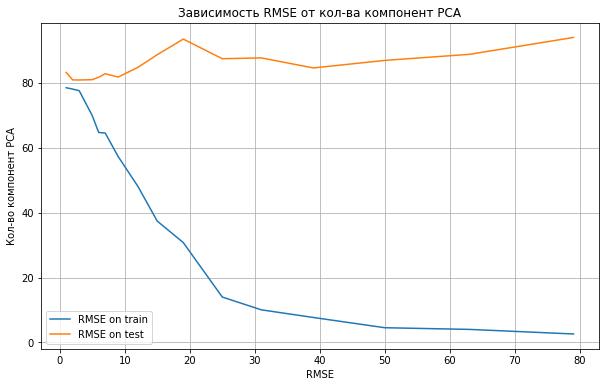

In [16]:
plt.figure(figsize=(10, 6))
plt.plot(metrics["pca_cnt"], metrics["train_rmse"], label="RMSE on train")
plt.plot(metrics["pca_cnt"], metrics["test_rmse"], label="RMSE on test")
plt.title("Зависимость RMSE от кол-ва компонент PCA")
plt.xlabel("RMSE")
plt.ylabel("Кол-во компонент PCA")
plt.legend()
plt.grid()
plt.show()

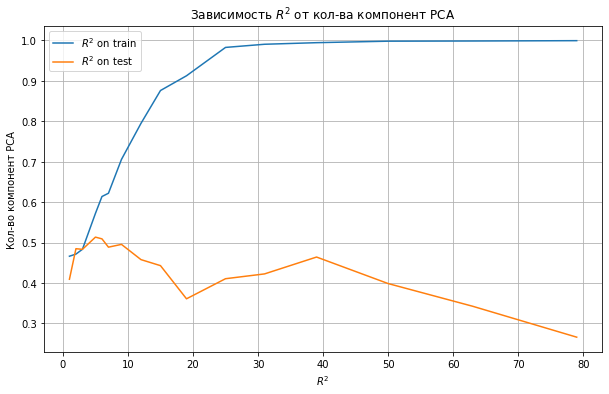

In [17]:
plt.figure(figsize=(10, 6))
plt.plot(metrics["pca_cnt"], metrics["train_r2"], label="$R^2$ on train")
plt.plot(metrics["pca_cnt"], metrics["test_r2"], label="$R^2$ on test")
plt.title("Зависимость $R^2$ от кол-ва компонент PCA")
plt.xlabel("$R^2$")
plt.ylabel("Кол-во компонент PCA")
plt.legend()
plt.grid()
plt.show()

In [19]:
metrics = []
for names in tqdm(Batch(images, BATCH_SIZE)):
    if len(names) < BATCH_SIZE:
        break
    # read images and data
    cat_names = names.copy()
    cat_target = []
    for cat_name in cat_names:
        with open(cat_name + ".cat") as f:
            cat_target.append([int(x) for x in f.read().split(" ")[1:-1]])
    cat_target = np.array(cat_target)
    cat_target = np.hstack([cat_target[:, ::2], cat_target[:, 1::2]])

    # make train and test datasets
    features_train = []
    features_test = []
    inputs = []
    target_train = []
    for i in range(len(cat_target)):
        im = cv2.imread(cat_names[i], cv2.IMREAD_COLOR)
        height, width = im.shape[:2]
        inputs.append({"height": height, "width": width})

        # середина feature map
        x = round(np.ceil(640 / FEATURE_MAP_SIZE) / 2)
        y = round(np.ceil(640 / FEATURE_MAP_SIZE) / 2)

        im_, x_target, y_target = preproc_img(im, cat_target[i][:9], cat_target[i][9:])
        # apply model
        xx = model([im_])
        t = torch.load("tensor.pt")

        if i < TRAIN_SIZE:
            for x_ in range(x - NUM_VEC, x + NUM_VEC + 1):
                for y_ in range(y - NUM_VEC, y + NUM_VEC + 1):
                    features_train.append(np.array(t[0, :, y_ - 1, x_ - 1]))
                    x_center = FEATURE_MAP_SIZE * (x_ + 0.5)
                    y_center = FEATURE_MAP_SIZE * (y_ + 0.5)
                    target_train.append(
                        np.hstack([(x_target - x_center) / FEATURE_MAP_SIZE, (y_target - y_center) / FEATURE_MAP_SIZE])
                    )

        for x_ in range(x - NUM_VEC, x + NUM_VEC + 1):
            for y_ in range(y - NUM_VEC, y + NUM_VEC + 1):
                features_test.append(np.array(t[0, :, y_ - 1, x_ - 1]))

    features_train = np.array(features_train)
    features_test = np.array(features_test)

    # fit regression
    pca = PCA(5, random_state=42)
    pca_train = pca.fit_transform(features_train)
    regr = LinearRegression().fit(pca_train, target_train)

    # predict key points
    pca_test = pca.transform(features_test)
    prediction = predict(pca_test, regr, inputs)

    metrics.append(
        [
            mean_squared_error(cat_target[:TRAIN_SIZE], prediction[:TRAIN_SIZE], squared=False),
            mean_squared_error(cat_target[TRAIN_SIZE:], prediction[TRAIN_SIZE:], squared=False),
            r2_score(cat_target[:TRAIN_SIZE], prediction[:TRAIN_SIZE]),
            r2_score(cat_target[TRAIN_SIZE:], prediction[TRAIN_SIZE:]),
        ]
    )

 98%|█████████▊| 53/54 [09:36<00:10, 10.88s/it]


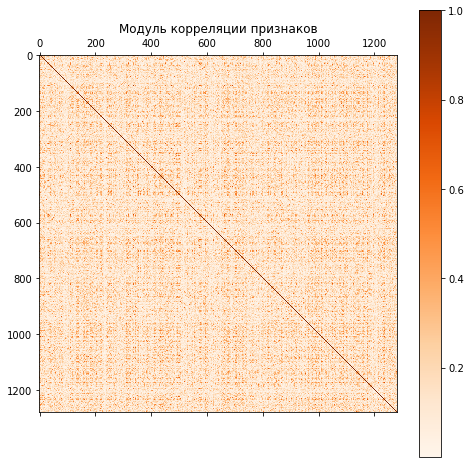

In [20]:
plt.figure(figsize=(8, 8))
plt.matshow(np.abs(np.corrcoef(features_train, rowvar=False)), cmap="Oranges", fignum=1)
plt.title("Модуль корреляции признаков")
plt.colorbar()
plt.show()

In [21]:
pd.DataFrame(metrics, columns=["train_rmse", "test_rmse", "train_r2", "test_r2"]).describe(percentiles=[])

,train_rmse,test_rmse,train_r2,test_r2
count,53.000000,53.000000,53.000000,53.000000
mean,60.136970,82.538555,0.694879,0.420504
std,12.603946,17.548882,0.122220,0.217937
min,36.315457,37.764743,0.243353,-0.296178
50%,60.658174,80.766766,0.715351,0.500877
max,92.302623,123.219376,0.900615,0.741585


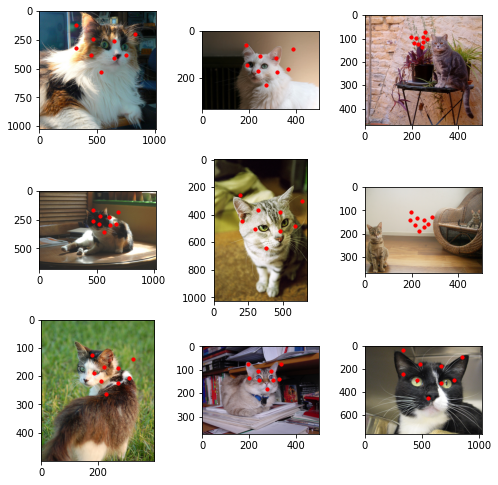

In [22]:
plt.figure(figsize=(7, 7), facecolor="w")
for i in range(9):
    plt.subplot(3, 3, i + 1)
    im = cv2.imread(cat_names[i], cv2.IMREAD_COLOR)
    im = cv2.cvtColor(im, cv2.COLOR_BGR2RGB)
    plt.imshow(im)
    plt.scatter(prediction[i][:9], prediction[i][9:], s=10, c="red")
plt.tight_layout()
plt.show()

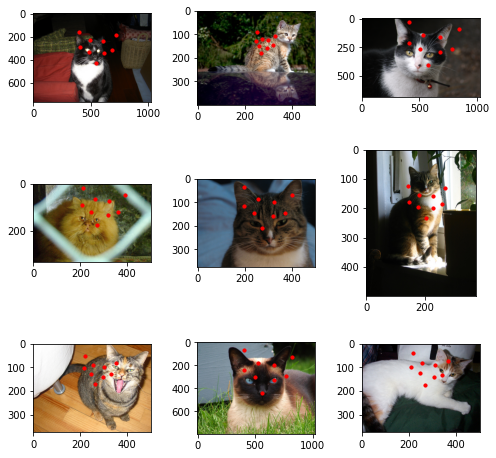

In [23]:
plt.figure(figsize=(7, 7), facecolor="w")
for i in range(9):
    plt.subplot(3, 3, i + 1)
    i = BATCH_SIZE - 9 + i
    im = cv2.imread(cat_names[i], cv2.IMREAD_COLOR)
    im = cv2.cvtColor(im, cv2.COLOR_BGR2RGB)
    plt.imshow(im)
    plt.scatter(prediction[i][:9], prediction[i][9:], s=10, c="red")
plt.tight_layout()
plt.show()

Некоторые (близкие) вектора feature map действительно сильно коррелируют между собой

(1280, 3, 3)


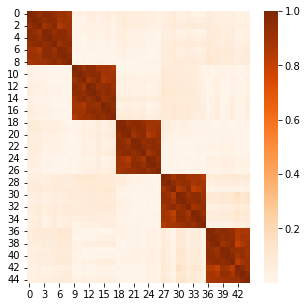

In [24]:
f = t[0, :, y - 1 : y + 2, x - 1 : x + 2].detach().numpy()
print(f.shape)
f = f.reshape((256, -1))
f = np.abs(pd.DataFrame(f).corr())
plt.figure(figsize=(5, 5), facecolor="w")
sns.heatmap(f, cmap=plt.cm.Oranges);

In [25]:
np.array(features_train).shape, np.array(target_train).shape

((784, 1280), (784, 18))

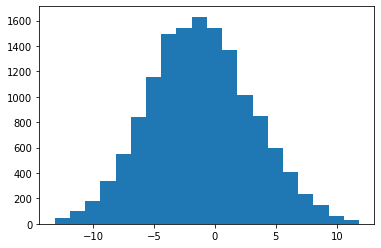

In [26]:
plt.hist(np.array(target_train).ravel(), bins=20);

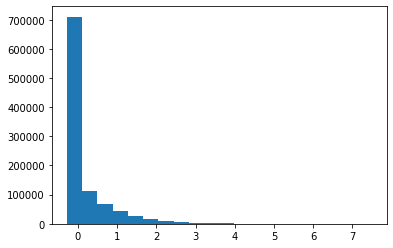

In [27]:
plt.hist(np.array(features_train).ravel(), bins=20);

## Augmentations

Исследуем влияние аугментации на решение задачи kpoints
* Наличие аугментаций с цветом и яркостью
* Наличие аугментаций с поворотом
* Наличие аугментаций с кропом
* Кол-во аугментаций

In [13]:
def pca_optimal(rotate_flag, crop_flag, n_aug):
    transform1_compose = [
        A.HueSaturationValue(p=1),
        A.RandomBrightnessContrast(p=1),
    ]
    if rotate_flag:
        transform1_compose.append(A.Rotate(limit=15, p=1))
    transform1 = A.Compose(
        transform1_compose,
        keypoint_params=A.KeypointParams(format="xy", remove_invisible=False),
    )

    transform2_compose = [
        A.RGBShift(p=1),
        A.RandomBrightnessContrast(p=1),
    ]
    if rotate_flag:
        transform2_compose.append(A.ShiftScaleRotate(rotate_limit=15, p=1))
    transform2 = A.Compose(
        transform2_compose,
        keypoint_params=A.KeypointParams(format="xy", remove_invisible=False),
    )

    metrics = []
    for names in tqdm(Batch(images, BATCH_SIZE)):
        if len(names) < BATCH_SIZE:
            break
        # read images and data
        cat_names = names.copy()
        cat_target = []
        for cat_name in cat_names:
            with open(cat_name + ".cat") as f:
                cat_target.append([int(x) for x in f.read().split(" ")[1:-1]])
        cat_target = np.array(cat_target)
        cat_target = np.hstack([cat_target[:, ::2], cat_target[:, 1::2]])

        # make train and test datasets
        features_train = []
        features_test = []
        inputs = []
        target_train = []
        for i in range(len(cat_target)):
            im = cv2.imread(cat_names[i], cv2.IMREAD_COLOR)
            height, width = im.shape[:2]
            inputs.append({"height": height, "width": width})

            # середина feature map
            x = round(np.ceil(640 / FEATURE_MAP_SIZE) / 2)
            y = round(np.ceil(640 / FEATURE_MAP_SIZE) / 2)

            im_, key_x, key_y = preproc_img(im, cat_target[i][:9], cat_target[i][9:])
            # apply model
            xx = model([im_])
            t = torch.load("tensor.pt")

            if i < TRAIN_SIZE:
                imgs = []
                cat_targets = [np.hstack([key_x, key_y])]
                kp_target = list(zip(cat_target[i][:9], cat_target[i][9:]))

                transform3 = A.Compose(
                    [
                        A.RandomSizedCrop(
                            min_max_height=(int(min(height, width) * 0.9), min(height, width)),
                            height=height,
                            width=width,
                            p=1,
                        ),
                        # A.OneOf([A.Rotate(p=0.8), A.ShiftScaleRotate(p=0.8)], p=1),
                        A.OneOf([A.HueSaturationValue(p=1), A.RGBShift(p=1)], p=1),
                        A.RandomBrightnessContrast(p=1),
                    ],
                    keypoint_params=A.KeypointParams(format="xy", remove_invisible=False),
                )

                for seed in range(n_aug):
                    random.seed(seed)
                    transformed = transform1(image=im, keypoints=kp_target)
                    kp = np.array(transformed["keypoints"])
                    im_, key_x, key_y = preproc_img(transformed["image"], kp[:, 0], kp[:, 1])
                    imgs.append(im_)
                    cat_targets.append(np.hstack([key_x, key_y]))

                    transformed = transform2(image=im, keypoints=kp_target)
                    kp = np.array(transformed["keypoints"])
                    im_, key_x, key_y = preproc_img(transformed["image"], kp[:, 0], kp[:, 1])
                    imgs.append(im_)
                    cat_targets.append(np.hstack([key_x, key_y]))

                    if crop_flag:
                        transformed = transform3(image=im, keypoints=kp_target)
                        kp = np.array(transformed["keypoints"])
                        im_, key_x, key_y = preproc_img(transformed["image"], kp[:, 0], kp[:, 1])
                        imgs.append(im_)
                        cat_targets.append(np.hstack([key_x, key_y]))

                # apply model
                xx = model(imgs)
                tt = torch.load("tensor.pt")
                tt = torch.cat((t, tt))

                for j in range(tt.shape[0]):
                    for x_ in range(x - NUM_VEC, x + NUM_VEC + 1):
                        for y_ in range(y - NUM_VEC, y + NUM_VEC + 1):
                            x_target = cat_targets[j][:9]
                            y_target = cat_targets[j][9:]
                            features_train.append(np.array(tt[j, :, y_ - 1, x_ - 1]))
                            x_center = FEATURE_MAP_SIZE * (x_ + 0.5)
                            y_center = FEATURE_MAP_SIZE * (y_ + 0.5)
                            target_train.append(
                                np.hstack(
                                    [(x_target - x_center) / FEATURE_MAP_SIZE, (y_target - y_center) / FEATURE_MAP_SIZE]
                                )
                            )

            for x_ in range(x - NUM_VEC, x + NUM_VEC + 1):
                for y_ in range(y - NUM_VEC, y + NUM_VEC + 1):
                    features_test.append(np.array(t[0, :, y_ - 1, x_ - 1]))

        features_train = np.array(features_train)
        features_test = np.array(features_test)

        # fit regression
        prange = np.unique(np.logspace(0, 1.9, 20).astype(int))
        for p in prange:
            if p > features_train.shape[0]:
                break
            pca = PCA(p, random_state=42)
            pca_train = pca.fit_transform(features_train)
            regr = LinearRegression().fit(pca_train, target_train)

            # predict key points
            pca_test = pca.transform(features_test)
            prediction = predict(pca_test, regr, inputs)

            metrics.append(
                [
                    p,
                    mean_squared_error(cat_target[:TRAIN_SIZE], prediction[:TRAIN_SIZE], squared=False),
                    mean_squared_error(cat_target[TRAIN_SIZE:], prediction[TRAIN_SIZE:], squared=False),
                    r2_score(cat_target[:TRAIN_SIZE], prediction[:TRAIN_SIZE]),
                    r2_score(cat_target[TRAIN_SIZE:], prediction[TRAIN_SIZE:]),
                ]
            )

        break
    return metrics

In [14]:
def fit_pca(rotate_flag, crop_flag, n_aug, n_pca):
    transform1_compose = [
        A.HueSaturationValue(p=1),
        A.RandomBrightnessContrast(p=1),
    ]
    if rotate_flag:
        transform1_compose.append(A.Rotate(limit=15, p=1))
    transform1 = A.Compose(
        transform1_compose,
        keypoint_params=A.KeypointParams(format="xy", remove_invisible=False),
    )

    transform2_compose = [
        A.RGBShift(p=1),
        A.RandomBrightnessContrast(p=1),
    ]
    if rotate_flag:
        transform2_compose.append(A.ShiftScaleRotate(rotate_limit=15, p=1))
    transform2 = A.Compose(
        transform2_compose,
        keypoint_params=A.KeypointParams(format="xy", remove_invisible=False),
    )

    metrics = []
    for names in tqdm(Batch(images, BATCH_SIZE)):
        if len(names) < BATCH_SIZE:
            break
        # read images and data
        cat_names = names.copy()
        cat_target = []
        for cat_name in cat_names:
            with open(cat_name + ".cat") as f:
                cat_target.append([int(x) for x in f.read().split(" ")[1:-1]])
        cat_target = np.array(cat_target)
        cat_target = np.hstack([cat_target[:, ::2], cat_target[:, 1::2]])

        # make train and test datasets
        features_train = []
        features_test = []
        inputs = []
        target_train = []
        for i in range(len(cat_target)):
            im = cv2.imread(cat_names[i], cv2.IMREAD_COLOR)
            height, width = im.shape[:2]
            inp = [{"height": height, "width": width}]
            inputs.append(inp[0])

            # середина feature map
            x = round(np.ceil(640 / FEATURE_MAP_SIZE) / 2)
            y = round(np.ceil(640 / FEATURE_MAP_SIZE) / 2)

            im_, key_x, key_y = preproc_img(im, cat_target[i][:9], cat_target[i][9:])
            # apply model
            xx = model([im_])
            t = torch.load("tensor.pt")

            if i < TRAIN_SIZE:
                imgs = []
                cat_targets = [np.hstack([key_x, key_y])]
                kp_target = list(zip(cat_target[i][:9], cat_target[i][9:]))

                transform3 = A.Compose(
                    [
                        A.RandomSizedCrop(
                            min_max_height=(int(min(height, width) * 0.9), min(height, width)),
                            height=height,
                            width=width,
                            p=1,
                        ),
                        # A.OneOf([A.Rotate(p=0.8), A.ShiftScaleRotate(p=0.8)], p=1),
                        A.OneOf([A.HueSaturationValue(p=1), A.RGBShift(p=1)], p=1),
                        A.RandomBrightnessContrast(p=1),
                    ],
                    keypoint_params=A.KeypointParams(format="xy", remove_invisible=False),
                )

                for seed in range(n_aug):
                    random.seed(seed)
                    transformed = transform1(image=im, keypoints=kp_target)
                    kp = np.array(transformed["keypoints"])
                    im_, key_x, key_y = preproc_img(transformed["image"], kp[:, 0], kp[:, 1])
                    imgs.append(im_)
                    cat_targets.append(np.hstack([key_x, key_y]))

                    transformed = transform2(image=im, keypoints=kp_target)
                    kp = np.array(transformed["keypoints"])
                    im_, key_x, key_y = preproc_img(transformed["image"], kp[:, 0], kp[:, 1])
                    imgs.append(im_)
                    cat_targets.append(np.hstack([key_x, key_y]))

                    if crop_flag:
                        transformed = transform3(image=im, keypoints=kp_target)
                        kp = np.array(transformed["keypoints"])
                        im_, key_x, key_y = preproc_img(transformed["image"], kp[:, 0], kp[:, 1])
                        imgs.append(im_)
                        cat_targets.append(np.hstack([key_x, key_y]))

                # apply model
                xx = model(imgs)
                tt = torch.load("tensor.pt")
                tt = torch.cat((t, tt))

                for j in range(tt.shape[0]):
                    for x_ in range(x - NUM_VEC, x + NUM_VEC + 1):
                        for y_ in range(y - NUM_VEC, y + NUM_VEC + 1):
                            x_target = cat_targets[j][:9]
                            y_target = cat_targets[j][9:]
                            features_train.append(np.array(tt[j, :, y_ - 1, x_ - 1]))
                            x_center = FEATURE_MAP_SIZE * (x_ + 0.5)
                            y_center = FEATURE_MAP_SIZE * (y_ + 0.5)
                            target_train.append(
                                np.hstack(
                                    [(x_target - x_center) / FEATURE_MAP_SIZE, (y_target - y_center) / FEATURE_MAP_SIZE]
                                )
                            )

            for x_ in range(x - NUM_VEC, x + NUM_VEC + 1):
                for y_ in range(y - NUM_VEC, y + NUM_VEC + 1):
                    features_test.append(np.array(t[0, :, y_ - 1, x_ - 1]))

        features_train = np.array(features_train)
        features_test = np.array(features_test)

        # fit regression
        pca = PCA(n_pca, random_state=42)
        pca_train = pca.fit_transform(features_train)
        regr = LinearRegression().fit(pca_train, target_train)

        # predict key points
        pca_test = pca.transform(features_test)
        prediction = predict(pca_test, regr, inputs)

        metrics.append(
            [
                mean_squared_error(cat_target[:TRAIN_SIZE], prediction[:TRAIN_SIZE], squared=False),
                mean_squared_error(cat_target[TRAIN_SIZE:], prediction[TRAIN_SIZE:], squared=False),
                r2_score(cat_target[:TRAIN_SIZE], prediction[:TRAIN_SIZE]),
                r2_score(cat_target[TRAIN_SIZE:], prediction[TRAIN_SIZE:]),
            ]
        )
    return metrics

### Эксперимент 1

In [30]:
pca_metrics = pca_optimal(rotate_flag=False, crop_flag=False, n_aug=1)

  0%|          | 0/54 [00:23<?, ?it/s]


In [31]:
pca_metrics = pd.DataFrame(pca_metrics, columns=["pca_cnt", "train_rmse", "test_rmse", "train_r2", "test_r2"])
pca_metrics

,pca_cnt,train_rmse,test_rmse,train_r2,test_r2
0,1,78.556782,83.191164,0.464712,0.408630
1,2,78.481392,81.393867,0.466484,0.471783
2,3,77.278691,80.660450,0.486839,0.484840
3,5,69.625144,81.214165,0.573253,0.507659
4,6,66.146283,81.872391,0.605093,0.504407
5,7,66.092252,82.256308,0.600564,0.490059
6,9,56.982570,81.285692,0.706434,0.496112
7,12,47.656851,83.346084,0.802116,0.468662
8,15,36.861857,88.620978,0.878788,0.444523
9,19,28.473733,90.806264,0.924745,0.390492


In [34]:
best_pca = int(pca_metrics.iloc[pca_metrics["test_rmse"].argmin()]['pca_cnt'])
metrics = fit_pca(rotate_flag=False, crop_flag=False, n_aug=1, n_pca=best_pca)

 98%|█████████▊| 53/54 [18:09<00:20, 20.56s/it]


In [35]:
pd.DataFrame(metrics, columns=["train_rmse", "test_rmse", "train_r2", "test_r2"]).describe(percentiles=[])

,train_rmse,test_rmse,train_r2,test_r2
count,53.000000,53.000000,53.000000,53.000000
mean,68.717847,84.304032,0.606324,0.376215
std,15.275328,17.276952,0.150687,0.266275
min,45.911950,43.803425,0.065237,-0.628553
50%,67.690585,81.708044,0.628786,0.453714
max,109.822656,120.341788,0.852909,0.738760


### Эксперимент 2

In [36]:
pca_metrics = pca_optimal(rotate_flag=True, crop_flag=False, n_aug=1)

  0%|          | 0/54 [00:23<?, ?it/s]


In [37]:
pca_metrics = pd.DataFrame(pca_metrics, columns=["pca_cnt", "train_rmse", "test_rmse", "train_r2", "test_r2"])
pca_metrics

,pca_cnt,train_rmse,test_rmse,train_r2,test_r2
0,1,77.714299,84.460740,0.479162,0.359805
1,2,79.293185,82.838829,0.457487,0.418199
2,3,76.587361,78.475872,0.489164,0.517026
3,5,67.644082,81.050969,0.606048,0.509926
4,6,65.243288,81.827929,0.601899,0.501555
5,7,64.990244,82.048505,0.610725,0.495433
6,9,57.615908,83.307867,0.699688,0.468572
7,12,50.806388,83.794977,0.777114,0.447490
8,15,40.928909,90.757155,0.850658,0.413336
9,19,33.451968,89.092324,0.893046,0.420491


In [38]:
best_pca = int(pca_metrics.iloc[pca_metrics["test_rmse"].argmin()]['pca_cnt'])
metrics = fit_pca(rotate_flag=True, crop_flag=False, n_aug=1, n_pca=best_pca)

 98%|█████████▊| 53/54 [17:45<00:20, 20.11s/it]


In [39]:
pd.DataFrame(metrics, columns=["train_rmse", "test_rmse", "train_r2", "test_r2"]).describe(percentiles=[])

,train_rmse,test_rmse,train_r2,test_r2
count,53.000000,53.000000,53.000000,53.000000
mean,69.819291,84.858776,0.589552,0.357598
std,15.594684,17.470545,0.157108,0.277571
min,45.779291,41.396129,0.084538,-0.663757
50%,68.994180,84.153708,0.624468,0.455570
max,110.941180,121.095172,0.846554,0.751885


### Эксперимент 3

In [15]:
pca_metrics = pca_optimal(rotate_flag=True, crop_flag=True, n_aug=1)

  0%|          | 0/54 [00:28<?, ?it/s]


In [16]:
pca_metrics = pd.DataFrame(pca_metrics, columns=["pca_cnt", "train_rmse", "test_rmse", "train_r2", "test_r2"])
pca_metrics

,pca_cnt,train_rmse,test_rmse,train_r2,test_r2
0,1,80.955116,85.626778,0.437300,0.379907
1,2,83.071067,83.281380,0.407769,0.443715
2,3,77.885079,79.868325,0.471412,0.510016
3,5,67.893325,84.285465,0.598893,0.477858
4,6,65.639173,83.713098,0.602785,0.481492
5,7,64.617211,84.275337,0.623867,0.472282
6,9,59.132696,86.673584,0.689892,0.438360
7,12,51.953351,85.034434,0.770552,0.428528
8,15,45.272276,91.375393,0.825515,0.375706
9,19,37.716849,92.728690,0.869883,0.366593


In [17]:
best_pca = int(pca_metrics.iloc[pca_metrics["test_rmse"].argmin()]['pca_cnt'])
metrics = fit_pca(rotate_flag=True, crop_flag=True, n_aug=1, n_pca=best_pca)

 98%|█████████▊| 53/54 [22:56<00:25, 25.97s/it]


In [18]:
pd.DataFrame(metrics, columns=["train_rmse", "test_rmse", "train_r2", "test_r2"]).describe(percentiles=[])

,train_rmse,test_rmse,train_r2,test_r2
count,53.000000,53.000000,53.000000,53.000000
mean,69.692338,85.297064,0.593787,0.352102
std,15.457824,18.290572,0.156131,0.283181
min,43.287213,41.663375,0.023981,-0.555802
50%,69.067870,84.238219,0.632458,0.404078
max,107.676570,120.034957,0.851238,0.776695


### Эксперимент 4

In [19]:
prange = np.unique(np.logspace(0, 1.2, 10).astype(int))
results = []
for p in prange:
    pca_metrics = pca_optimal(rotate_flag=True, crop_flag=False, n_aug=p)
    pca_metrics = pd.DataFrame(pca_metrics, columns=["pca_cnt", "train_rmse", "test_rmse", "train_r2", "test_r2"])
    res = pca_metrics.iloc[pca_metrics["test_rmse"].argmin()].to_dict()
    res["aug_cnt"] = p
    results.append(res)

  0%|          | 0/54 [03:37<?, ?it/s]


In [20]:
pd.DataFrame(results)

,pca_cnt,train_rmse,test_rmse,train_r2,test_r2,aug_cnt
0,3.0,76.587361,78.475872,0.489164,0.517026,1
1,3.0,78.577120,78.949898,0.454796,0.514191,2
2,3.0,78.269166,78.811024,0.454956,0.512176,3
3,3.0,77.802025,78.769723,0.460842,0.514336,4
4,3.0,77.968809,78.784227,0.455881,0.513868,6
5,3.0,77.377583,78.592797,0.466889,0.517213,8
6,3.0,77.605738,78.443762,0.460860,0.516306,11
7,3.0,77.258438,78.098004,0.468572,0.521823,15


## Минимальное кол-во изображений обучающей выборки для решений задачи kpoints

In [21]:
prange = np.unique(np.logspace(0, 1.2, 10).astype(int))
results = []
for p in prange[1:]:
    TRAIN_SIZE = p
    pca_metrics = pca_optimal(rotate_flag=True, crop_flag=False, n_aug=5)
    pca_metrics = pd.DataFrame(pca_metrics, columns=["pca_cnt", "train_rmse", "test_rmse", "train_r2", "test_r2"])
    res = pca_metrics.iloc[pca_metrics["test_rmse"].argmin()].to_dict()
    res["train_size"] = p
    results.append(res)

  0%|          | 0/54 [01:16<?, ?it/s]


In [22]:
pd.DataFrame(results)

,pca_cnt,train_rmse,test_rmse,train_r2,test_r2,train_size
0,39.0,2.145640,99.054718,0.992766,0.211070,2
1,7.0,5.911636,91.308298,0.987400,0.259680,3
2,9.0,6.359334,92.244822,0.982909,0.335848,4
3,1.0,61.410655,93.405446,0.327681,0.361174,6
4,3.0,68.533374,85.618234,0.327310,0.435056,8
5,1.0,77.929602,85.078443,0.069033,0.426696,11
6,3.0,75.487128,81.167750,0.518822,0.472978,15


## Оптимальное кол-во векторов feature map для решения задачи kpoints

In [23]:
TRAIN_SIZE = 16

In [24]:
results = []
for p in np.arange(6):
    NUM_VEC = p
    pca_metrics = pca_optimal(rotate_flag=True, crop_flag=False, n_aug=5)
    pca_metrics = pd.DataFrame(pca_metrics, columns=["pca_cnt", "train_rmse", "test_rmse", "train_r2", "test_r2"])
    res = pca_metrics.iloc[pca_metrics["test_rmse"].argmin()].to_dict()
    res["num_vec"] = p
    results.append(res)

  0%|          | 0/54 [01:25<?, ?it/s]


In [25]:
pd.DataFrame(results)

,pca_cnt,train_rmse,test_rmse,train_r2,test_r2,num_vec
0,3.0,71.198095,85.380707,0.554202,0.352360,0
1,3.0,71.290091,84.425142,0.552740,0.379625,1
2,3.0,72.905662,83.952945,0.530600,0.393326,2
3,3.0,78.780537,79.291376,0.440229,0.508010,3
4,3.0,80.800464,80.223604,0.392117,0.488153,4
5,1.0,82.986367,80.508525,0.398325,0.475720,5
